Si vous utilisez Google Colab, exécutez d'abord la cellule ci-dessous. La cellule présume que le code du TP1 (le dossier prog) se trouve dans MyDrive/IFT780/TP1/. Si ce n'est pas le cas, changez le chemin pour le vôtre. 

In [ ]:
# à exécuter uniquement sur les serveurs de google colab
from google.colab import drive
drive.mount('/content/drive')
!cp -r drive/MyDrive/IFT780/TP1/prog/* .

# TP1: Réseau de neurones à deux couches, fonction de perte **Entropie croisée**

In [1]:
import random
import numpy as np
from utils.data_utils import load_CIFAR10
from utils.data_utils import display_images
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# pour automatiquement recharger les modules externes
# voir http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

<font size=5>MLP à deux couches</font>

Ici, nous développerons un **réseau pleinement connecté** à deux couches avec **softmax** et **entropie croisée**.  En principe, vous devriez avoir pris connaissance du notebook "tp1_simple_neural_net.ipynb".  Le but ici est d'enchasser les différents éléments d'un réseau de neurones dans des **classes**.

Pour commencer, allons-y avec un petit réseau à 

* **10 neurones cachées**
* **3 classes** 
* un vecteur d'entrée de taille **4**.

Avant de commencer, vous devez vous familier avec les classes **model.Model**, **layers.Dense** et la loss **cross_entropy_loss** (cette dernière comprend le softmax + la loss)

Le code à produire se situe : 

* dans la classe **Dense** (répertoire layer)
* dans la fonction **cross_entropy_loss** (dans utils.model_loss)
* dans le fichier **activations.py** (répetoire utils)

À ce point-ci, l'entropie croisée (et son gradient) que vous avez codé précédemment **doit être fonctionnelle**.  Ce code peut donc en bonne partie être récupéré ici.

In [13]:
##############################################################################
# On crée un modèle jouet pour rapidement tester les différentes composantes #
# La classe Model encapsule et relie les différentes couches de notre        #
# réseau de neurones.                                                        #
##############################################################################
from model.Model import Model
from layers.Dense import Dense
from utils.model_loss import cross_entropy_loss

hidden_size = 10
num_classes = 3
input_size = 4

def create_toy_model():
    np.random.seed(0)
    model = Model()
    model.add(Dense(input_size, hidden_size, weight_scale=1e-1, activation='relu'))
    model.add(Dense(hidden_size, num_classes, weight_scale=1e-1))
    model.add_loss(cross_entropy_loss)
    return model

model = create_toy_model()

In [14]:
def create_random_toy_data(nb_elements, input_size, nb_classes):
    np.random.seed(1)
    
    X = 10 * np.random.randn(nb_elements, input_size)
    y = np.random.randint(nb_classes, size=nb_elements)
        
    return X, y

In [4]:
x,y=create_random_toy_data(1, 5, 3)
x.shape

(1, 5)

### Commençons avec la prédiction d'**un seul vecteur d'entrée** de taille 4 et dont la cible est 0.  Ici, le **score** est la sortie du réseau avant la **softmax**

In [15]:
##############################################################################
# TODO: Implémenter la méthode forward (propagation avant) de la classe de   #
# couche Dense.                                                              #
##############################################################################
X, y = create_random_toy_data(1, input_size, num_classes)

scores = model.forward(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([[-0.81233741, -1.27654624, -0.70335995]])
print(correct_scores)
print()

# La différence devrait être assez basse, en principe inférieure à 1e-7.
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]]

Difference between your scores and correct scores:
5.897841770519108e-09


In [16]:
##############################################################################
# TODO: Implémenter le calcul de perte vectorisé adapté pour un réseau de    #
# neurones dans la fonction softmax_loss. La différence avec la softmax      #
# implémentée dans la partie précédente est que la dérivée retournée par     #
# softmax_loss est en fonction des scores, et non en fonction des poids      #
##############################################################################

loss, _, softmax = model.calculate_loss(scores, y, 0.1)
print('Softmax: ', softmax)
print('Loss: ', loss)

correct_loss = 0.938286073616293
correct_softmax = np.asarray([0.3644621, 0.22911264, 0.40642526])

print('\nCorrect loss: ', correct_loss)
print('Difference between your loss and correct loss:')
# on devrait obtenir une erreur de loss inférieure à 1e-9.
print(np.sum(np.abs(loss - correct_loss)))

# on devrait obtenir une erreur de softmax inférieure à 1e-7.
print('\nDifference between your softmax and correct softmax:')
print(np.sum(np.abs(correct_softmax - softmax)))

Softmax:  [[0.3644621  0.22911264 0.40642526]]
Loss:  0.9382860736162932

Correct loss:  0.938286073616293
Difference between your loss and correct loss:
2.220446049250313e-16

Difference between your softmax and correct softmax:
8.204646462228737e-09


### Maintenant allons-y avec la prédiction de **5 vecteurs d'entrée** de taille 4 et dont la cible est 0.  Ici, le **score** est la sortie du réseau avant la **softmax**

In [17]:
##############################################################################
# TODO: Implémenter la méthode forward (propagation avant) de la classe de   #
# couche Dense.                                                              #
##############################################################################
X, y = create_random_toy_data(5, input_size, num_classes)

scores = model.forward(X)
print('Your scores:')
print(scores)
print()
print('Correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print()

# La différence devrait être assez basse, en principe inférieure à 1e-7.
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.6802720745909845e-08


In [18]:
##############################################################################
# TODO: Implémenter le calcul de perte vectorisé adapté pour un réseau de    #
# neurones dans la fonction softmax_loss. La différence avec la softmax      #
# implémentée dans la partie précédente est que la dérivée retournée par     #
# softmax_loss est en fonction des scores, et non en fonction des poids      #
#                                                                            #
# Code à modifier dans "calculate_loss" du fichier model_loss.py             #
##############################################################################

loss, _, softmax = model.calculate_loss(scores, y, 0.1)
print('Softmax: ', softmax)
print('Loss: ', loss)

correct_loss = 1.06368300738

correct_softmax = np.asarray([
    [0.3644621,  0.22911264, 0.40642526],
    [0.47590629, 0.17217039, 0.35192332],
    [0.43035767, 0.26164229, 0.30800004],
    [0.41583127, 0.2983228,  0.28584593],
    [0.36328815, 0.32279939, 0.31391246]])

# on devrait obtenir une erreur de loss inférieure à 1e-10.
print('\nCorrect loss: ', correct_loss)
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

# on devrait obtenir une erreur de softmax inférieure à 1e-7.
print('\nDifference between your softmax and correct softmax:')
print(np.sum(np.abs(softmax - correct_softmax)))


Softmax:  [[0.3644621  0.22911264 0.40642526]
 [0.47590629 0.17217039 0.35192332]
 [0.43035767 0.26164229 0.30800004]
 [0.41583127 0.2983228  0.28584593]
 [0.36328815 0.32279939 0.31391246]]
Loss:  1.0636830073861907

Correct loss:  1.06368300738
Difference between your loss and correct loss:
6.190603585309873e-12

Difference between your softmax and correct softmax:
2.9173411658645065e-08


# Rétropropagation

Maintenant vous devez rédiger la **rétro-progatation** de la classe **model**.  Vos gradients seront testés avec un gradient numérique.

In [21]:
##############################################################################
# TODO: Implémenter la méthode backward (rétro-propagation) de la classe de  #
# couche Dense, ainsi que la méthode backward de la classe Model.            #
##############################################################################
loss, dScores, softmax = model.calculate_loss(scores, y, 0.1)

_ = model.backward(dScores)  # les gradients sont stockés dans les objets "layers" du modèle

In [22]:
from utils.gradients import evaluate_numerical_gradient

# Retourne l'erreur relative maximale des matrices de gradients passées en paramètre.
# Pour chaque paramètre, l'erreur relative devrait être inférieure à environ 1e-8.
def rel_error(x, y):
    rel = np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y)))
    return np.max(rel)

gradients = model.gradients()
model_params = model.parameters()

# Si tout va bien, vous devriez avoir des erreurs inférieurs à 1e-8
for layer_name, layer_params in model_params.items():
    for param_name, _ in layer_params.items():
        grad_num = evaluate_numerical_gradient(X, y, model, layer_name, param_name, reg=0.1)
        max_error = rel_error(grad_num, gradients[layer_name][param_name])
        print('%s max relative error: %e' % (layer_name + '-' + param_name, max_error))

L0-W max relative error: 3.561318e-09
L0-b max relative error: 6.304493e-10
L1-W max relative error: 3.440708e-09
L1-b max relative error: 6.665470e-11


# Entraînement

Il est maintanant temps de rédiger le code de la descente de gradient devant permettre d'entraîner le modèle.  Le code à rédiger est dans le fichier **model/Solver.py**.  Si votre code fonctionne, le graphique de la loss devrait **descendre**.

iteration 0 / 100: loss 1.029545
Final training loss:  0.03295504011128467


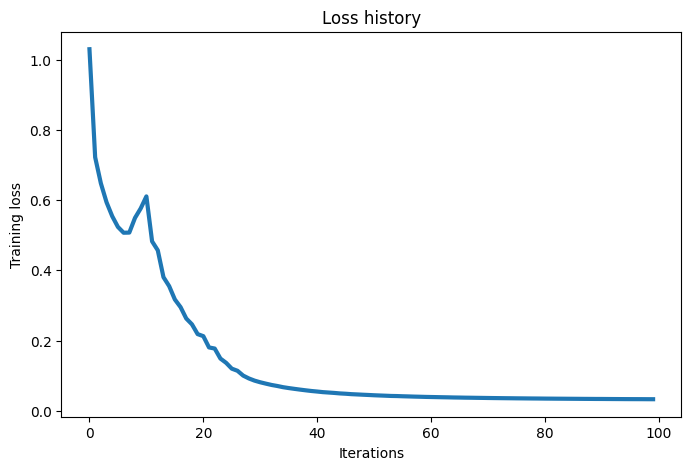

In [25]:
from visualization.utils import visualize_loss
from model.Solver import solver, SGD

model = create_toy_model()
sgd_optimizer = SGD(1e-1, model)

#
# TODO
# Ajouter code de descente de gradient dans la fonction solver du fichier Solver.py
#
loss_history, _, _ = solver(X, y, X, y, 1e-2, sgd_optimizer, num_iter=100)

print('Final training loss: ', loss_history[-1])

# Visualisation de l'historique de perte lors de l'entraînement
visualize_loss(loss_history)

<font size="5">Classifieur d'images</font>

Si votre code fonctionne bien, vous devriez être capable d'entraîner un modèle sur CIFAR10

In [28]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500, num_batch=200):
    """
    Charger la banque de données CIFAR-10, prétraiter les images et ajouter une dimension pour le biais.
    
    Input :
    - num_training : nombre d'images à mettre dans l'ensemble d'entrainement
    - num_validation : nombre d'images à mettre dans l'ensemble de validation
    - num_test : nombre d'images à mettre dans l'ensemble de test
    - num_dev : d'images à mettre dans l'ensemble dev
    
    Output :
    - X_train, y_train : données et cibles d'entrainement
    - X_val, y_val: données et cibles de validation
    - X_test y_test: données et cibles de test 
    - X_dev, y_dev: données et cibles dev
    - X_batch, y_batch: batch de données et de cibles 
    """
    # Charger les données CIFAR-10
    cifar10_dir = 'datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test, label_names = load_CIFAR10(cifar10_dir)
  
    # Séparer en ensembles d'entraînement, de validation, de test et de dev
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    mask = range(num_batch)
    X_batch = X_train[mask]
    y_batch = y_train[mask]
    
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    X_batch = np.reshape(X_batch, (X_batch.shape[0], -1))

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev, X_batch, y_batch, label_names 

def preprocess_CIFAR10_data(X):

    # Normalisation
    X_mean = np.mean(X, axis = 0)
    X_ = X - X_mean
    
    return X_

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)
dev data shape:  (500, 3072)
dev labels shape:  (500,)
batch data shape:  (200, 3072)
batch labels shape:  (200,)
CIFAR10 est un jeu de données d'images RGB 32x32x3 séparées en 10 classes
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


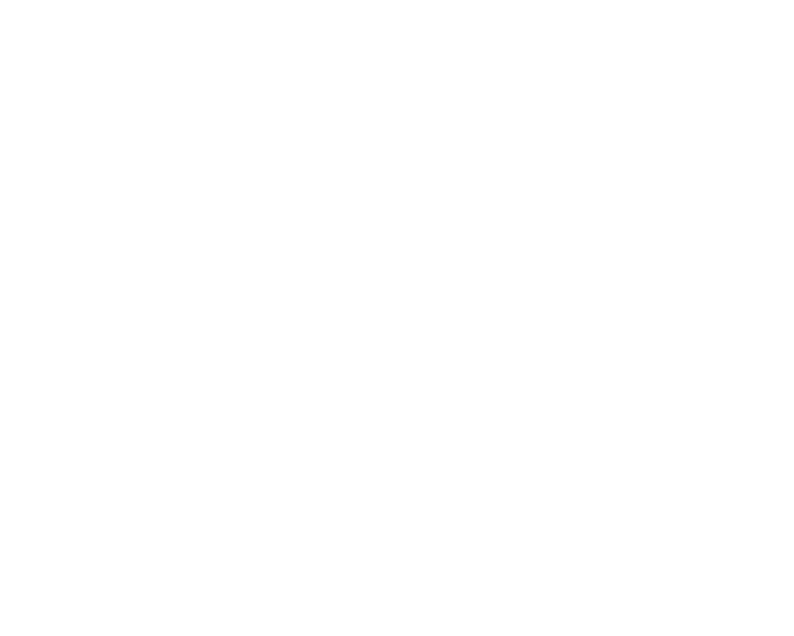

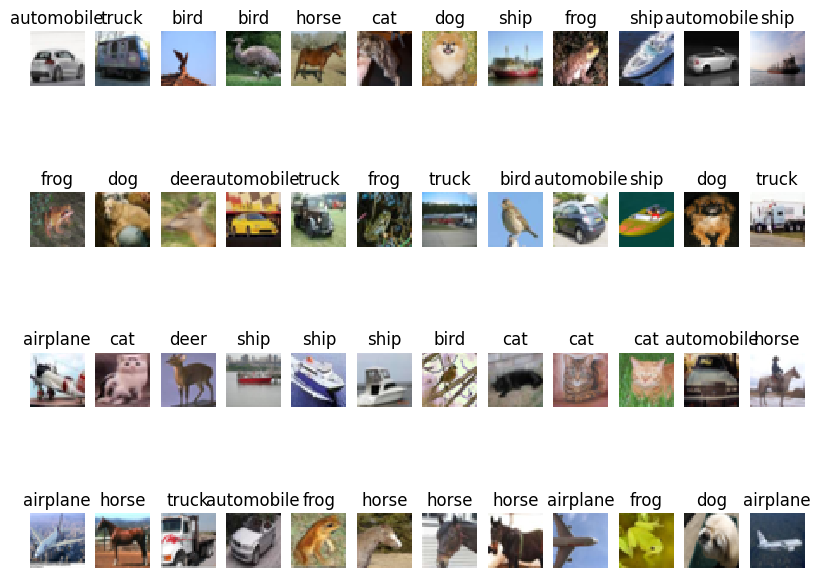

In [29]:
Data_train, y_train, Data_val, y_val, Data_test, y_test, Data_dev, y_dev, Data_batch, y_batch, label_names = get_CIFAR10_data()
X_train, X_val, X_test, X_dev, X_batch, = (preprocess_CIFAR10_data(Data) for Data in (Data_train, Data_val, Data_test, Data_dev, Data_batch))

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)
print('batch data shape: ', X_batch.shape)
print('batch labels shape: ', y_batch.shape)


    
print("CIFAR10 est un jeu de données d'images RGB 32x32x3 séparées en 10 classes")
print(label_names)

display_images(Data_train, y_train, label_names)

In [30]:
# Si le modèle et toutes ses composantes ont bien été implémentées
# à l'étape du modèle jouet,
def create_model(hidden_size):
    model = Model()
    model.add(Dense(dim_input=3*32*32, dim_output=hidden_size, activation='relu'))
    model.add(Dense(dim_input=hidden_size, dim_output=10))
    model.add_loss(cross_entropy_loss)
    return model
    
model = create_model(50)

scores = model.forward(X_dev)

In [37]:
loss, dScores, softmax = model.calculate_loss(scores, y_dev, 0.5)

# La loss d'un modèle non-entrainé devrait s'approcher de -log(0.1).
print('loss: %f' % loss)
print('sanity check loss: %f' % (-np.log(0.1)))

print('dScores shape: ', dScores.shape)
print('softmax shape: ', softmax.shape)

loss: 2.306523
sanity check loss: 2.302585
dScores shape:  (500, 10)
softmax shape:  (500, 10)


In [38]:
optimizer = SGD(8e-5, model)

loss_history, train_accuracy, val_accuracy = solver(X_train, y_train, X_val, y_val, 0.5, optimizer, lr_decay=0.98, num_iter=3000)

print('Final training loss: ', loss_history[-1])

0
iteration 0 / 3000: loss 2.004056
50
100
150
200
250
300
350
400
450
500
iteration 500 / 3000: loss 1.890515
550
600
650
700
750
800
850
900
950
1000
iteration 1000 / 3000: loss 1.831143
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
iteration 1500 / 3000: loss 1.731183
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
iteration 2000 / 3000: loss 1.745403
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
iteration 2500 / 3000: loss 1.672229
2550
2600
2650
2700
2750
2800
2850
2900
2950
Final training loss:  1.7698373302116523


<font size=5>Visualisation</font>

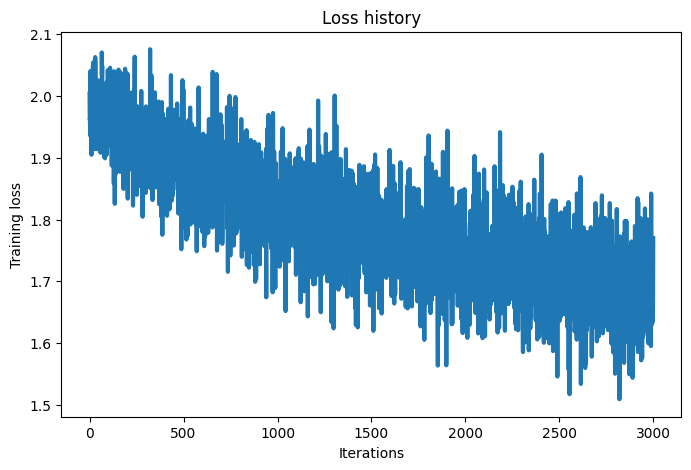

In [39]:
from visualization.utils import visualize_loss

# Visualisation de l'historique de loss de l'entraînement
visualize_loss(loss_history)

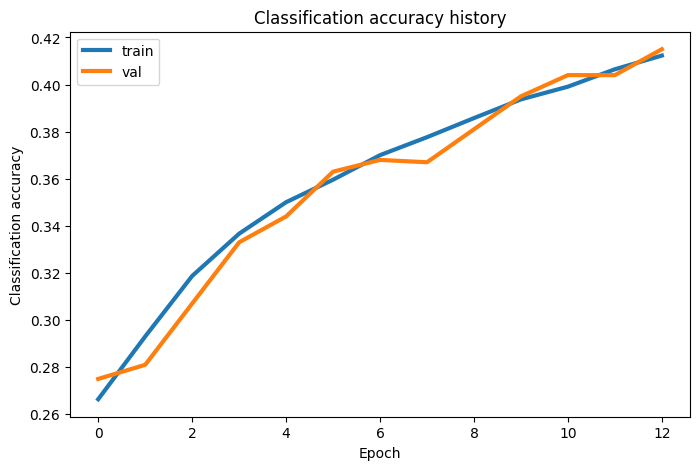

In [40]:
from visualization.utils import visualize_accuracy

# Visualisation de l'historique d'accuracy lors de l'entraînement.
# Ceci inclut la accuracy d'entraînement et la accuracy de validation
visualize_accuracy(train_accuracy, val_accuracy)

# Si la accuracy de validation est proche de 0.4, c'est bon signe

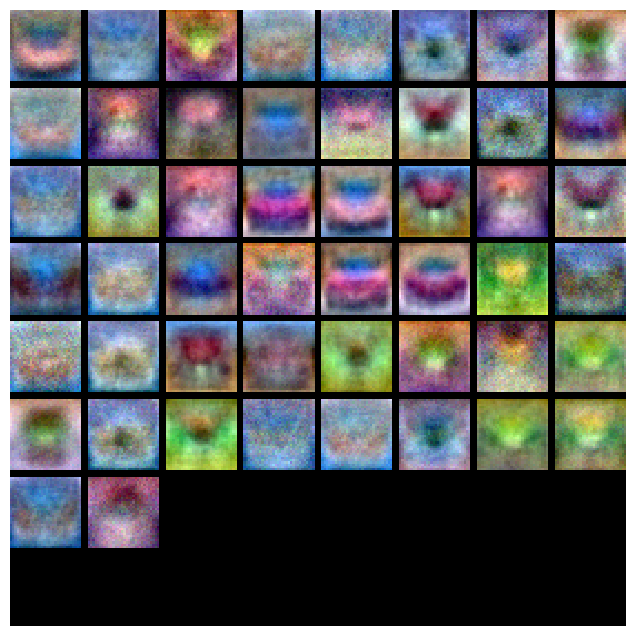

In [41]:
from visualization.utils import visualize_as_grid

def show_net_weights(model):
  W1 = model.parameters()['L0']['W']
  W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
  plt.imshow(visualize_as_grid(W1, padding=3).astype('uint8'))
  plt.gca().axis('off')
  plt.show()

show_net_weights(model)

## Recherche d'hyper-paramètres

Tout comme dans le notebook précédent, veuillez rédiger du code afin de trouver les meilleurs taux d'apprentissage et terme de régularisation.

In [43]:
best_model = None 
best_val_acc = 0.0
best_loss = None
best_train_acc = 0.0
best_params = None

from itertools import product as itprod

lr_list = 10 ** np.linspace(-4, -3, 4)
reg_list = 10 ** np.linspace(-7, -3, 4)
hs = 200
nb_iter = 1000

# Mettre les résultats des meilleurs hyper-paramètres dans les variables *best_ABC* définis ci-haut.
# Avec 1000 iterations par entrainement, vous devriez obtenir une justesse de validation de 39%.

for lr in lr_list:
    for reg in reg_list:
        model = create_model(hs)
        scores = model.forward(X_dev)
        loss, dScores, softmax = model.calculate_loss(scores, y_dev, reg)
        optimizer = SGD(lr, model)
        loss_history, train_accuracy, val_accuracy = solver(X_train, y_train, X_val, y_val, reg, optimizer, num_iter=nb_iter)
        if best_model is None or best_val_acc[-1] < val_accuracy[-1]:
            best_model = model
            best_val_acc = val_accuracy
            best_loss = loss_history
            best_train_acc = train_accuracy
            best_params = [lr, reg]
            

iteration 0 / 1000: loss 2.302584
iteration 500 / 1000: loss 2.003716
iteration 0 / 1000: loss 2.302602
iteration 500 / 1000: loss 2.151517
iteration 0 / 1000: loss 2.302679
iteration 500 / 1000: loss 2.087871
iteration 0 / 1000: loss 2.302612
iteration 500 / 1000: loss 2.040633
iteration 0 / 1000: loss 2.302577
iteration 500 / 1000: loss 1.782217
iteration 0 / 1000: loss 2.302621
iteration 500 / 1000: loss 1.901180
iteration 0 / 1000: loss 2.302622
iteration 500 / 1000: loss 1.880500
iteration 0 / 1000: loss 2.302635
iteration 500 / 1000: loss 1.787303
iteration 0 / 1000: loss 2.302600
iteration 500 / 1000: loss 1.698945
iteration 0 / 1000: loss 2.302535
iteration 500 / 1000: loss 1.669842
iteration 0 / 1000: loss 2.302540
iteration 500 / 1000: loss 1.676012
iteration 0 / 1000: loss 2.302621
iteration 500 / 1000: loss 1.696533
iteration 0 / 1000: loss 2.302586
iteration 500 / 1000: loss 1.677175
iteration 0 / 1000: loss 2.302591
iteration 500 / 1000: loss 1.574773
iteration 0 / 1000: 

Best: [0.001, 2.1544346900318822e-06]


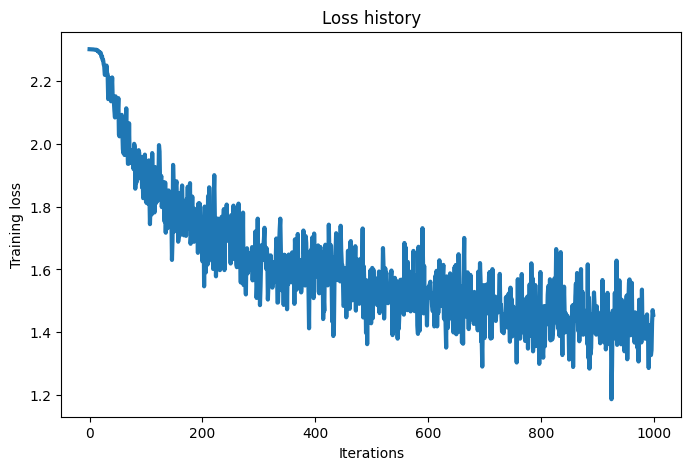

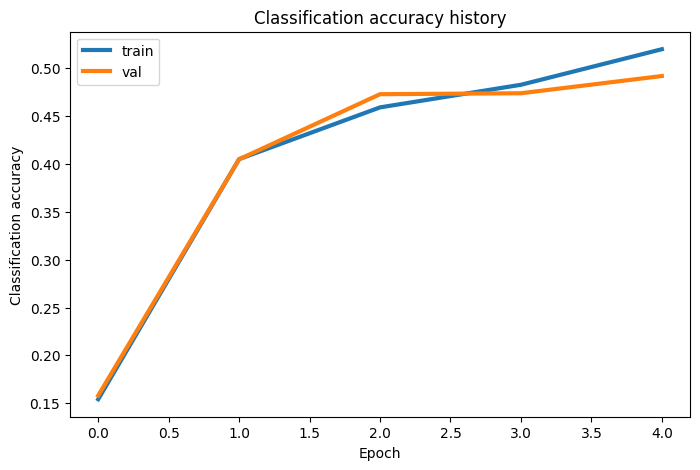

In [44]:
print('Best: {}'.format(best_params))
# Visualisation de l'historique de perte lors de l'entraînement
visualize_loss(best_loss)

# Visualisation de l'historique d'accuracy lors de l'entraînement.
# Ceci inclut la accuracy d'entraînement et la accuracy de validation
visualize_accuracy(best_train_acc, best_val_acc)

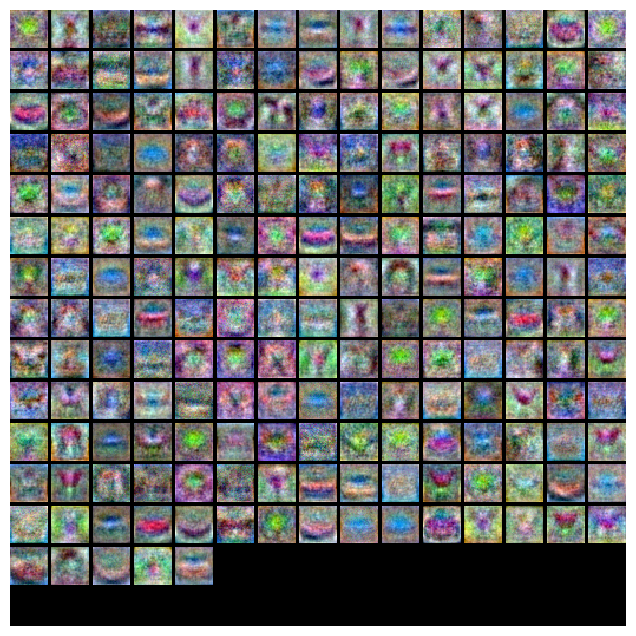

In [45]:
show_net_weights(best_model)

In [46]:
# Si tout va bien, vous devriez obtenir un justesse sur l'ensemble de test de 45% ou plus.
test_acc = (best_model.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.493
